In [1]:
# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

import numpy as np
from keras import layers, models, optimizers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
% matplotlib inline
from PIL import Image
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
(X, Y), (x_test, y_test) = mnist.load_data()
X = X.reshape(-1,28,28,1)
x_train, x_test, y_train, y_test, = train_test_split(X, Y, test_size=0.2, shuffle=True)

In [3]:
# one hot encode the labels:
from sklearn import preprocessing
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
y_test = onehot_encoder.fit_transform(y_test.reshape(-1,1))
y_train = onehot_encoder.fit_transform(y_train.reshape(-1,1))

In [4]:
input_shape = (28,28,1)
routings = 3

n_class = 10

x = layers.Input(shape=input_shape)

# Layer 1: Just a conventional Conv2D layer
conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

# Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')


# Layer 3: Capsule layer. Routing algorithm works here.
digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                         name='digitcaps')(primarycaps)

# Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
# If using tensorflow, this will not be necessary. :)
out_caps = Length(name='capsnet')(digitcaps)

# Decoder network.
y = layers.Input(shape=(n_class,))
masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

# Shared Decoder model in training and prediction
decoder = models.Sequential(name='decoder')
decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
decoder.add(layers.Dense(1024, activation='relu'))
decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

# Models for training and evaluation (prediction)
train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

# compile the model
train_model.compile(optimizer=optimizers.Adam(lr=0.0003),
              loss=[margin_loss, 'mse'],
              loss_weights=[1., 0.392],
              metrics={'capsnet': 'accuracy'})


In [5]:
train_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 1152, 8)      0           primarycap_conv2d[0][0]          
__________________________________________________________________________________________________
primarycap

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, LearningRateScheduler, Callback
import math
lr = 0.0003
lr_decay = 0.9

log = CSVLogger('/home/amplifier/home/NEW_DL/logs/CapsNET_log.csv')

checkpointer = ModelCheckpoint(filepath='/home/amplifier/home/NEW_DL/weights/CapsNET.h5',
                               verbose=1,
                               monitor='val_capsnet_acc',
                               save_best_only=True)

def step_decay(epoch):
    initial_lrate = 0.003
    drop = 0.5
    epochs_drop = 1.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    print('lrate=', lrate, sep="")
    return lrate

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        self.batch_loss = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
#         plt.plot(self.batch_loss)

    def on_batch_end(self, batch, logs={}):
        print('__', logs.get('capsnet_loss'))
        self.batch_loss.append(logs.get('capsnet_loss'))
        

lr_decay = LearningRateScheduler(schedule=step_decay)
loss_history = LossHistory()

train_model.fit(
    [x_train, y_train],
    [y_train, x_train],
    batch_size=250,
    epochs=20,
    validation_data=[[x_test, y_test], [y_test, x_test]],
    callbacks=[log, checkpointer, loss_history, lr_decay])

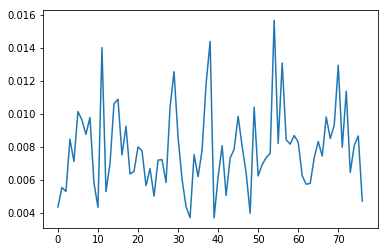

In [26]:
plt.plot(loss_history.batch_loss)

In [9]:
y_pred, x_recon = train_model.predict([x_test[None,1,:,:,:], y_test[None,1,:]])

In [10]:
print(y_pred)

[[2.8306940e-03 9.1205275e-01 6.5357224e-03 2.1315979e-02 2.8726222e-02
  2.6353458e-03 7.1503822e-04 1.6000703e-02 4.1158564e-02 5.9690364e-03]]


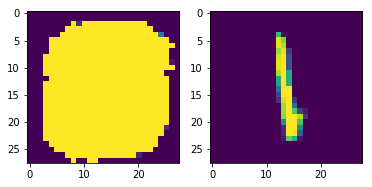

In [11]:
plt.subplot(121)
plt.imshow(x_recon[-1,:,:,-1])
plt.subplot(122)
plt.imshow(x_test[1,:,:,-1])

In [12]:
x_recon.shape

(1, 28, 28, 1)